# Multi-deme WF simulator and SFS calculator
#### Chris Porras

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
%matplotlib inline

### WF Simulator with stepping stone migration
Introduces migration as per the Kimura stepping stone model. Simulates a 1D ring of demes, or subpopulations connected by a symmettric migration rate $m$.

In [6]:
def SS_WF_sim(N,mu,s,m,num_reps,num_gen,num_demes,p0):
    f = np.zeros((num_gen+1,num_reps,num_demes))
    f[0] = np.repeat(np.repeat(p0,num_reps),
                     num_demes).reshape(num_reps,num_demes)
    for j in range(num_gen):
        for i in range(num_demes):
            if (i+1) >= num_demes:
                i = i - num_demes
            df = mu*(1-2*f[j,:,i])-s*f[j,:,i]*(1-f[j,:,i])+m*(f[j,:,i-1]+f[j,:,i+1]-2*f[j,:,i])
            p = f[j,:,i] + df #add change in frequency
            p = np.clip(a=p,a_min=0,a_max=1) #bounds allele frequencies
            f[j+1,:,i]= np.random.binomial(N,p)/N #genetic drift sampling
    return f

In [7]:
# Define parameters for 1D chain of demes
s = 10**-2 # selection rate
N = 10**3 # population size
mu = 10**-4 # mutation rate
m = 0.1 # migration rate
num_demes = 50 # number of demes simulated
num_reps = 1000 # number of independent sites simulated
num_gen = 10**4 # number of simulation generations
p0 = 0.1 # initial allele frequency

n = 1 # SFS sampling parameter

In [8]:
f = SS_WF_sim(N,mu,s,m,num_reps,num_gen,num_demes,p0)

### Simulation confirmations and visualizations 

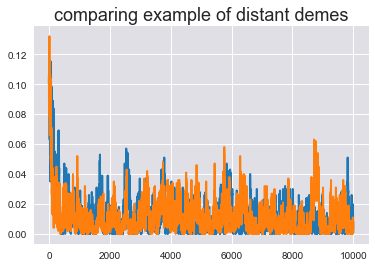

In [8]:
plt.plot(f[:,0,0]) # [all time, first locus, first deme]
plt.plot(f[:,0,30]) 
plt.title("comparing example of distant demes")
plt.show()

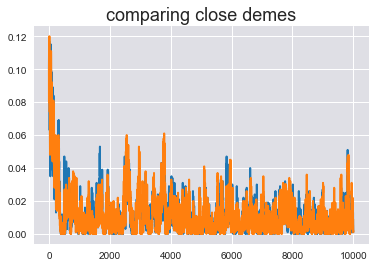

In [9]:
plt.plot(f[:,0,0]) # [all time, first locus, first deme]
plt.plot(f[:,0,-1]) 
plt.title("comparing close demes")
plt.show()

In [10]:
print("avg deviation from mut-sel balance:",abs(np.mean(mu/s - np.mean(f,axis=(0,1)))))

avg deviation from mut-sel balance: 0.0009188713046600963


## *Sampling*

### Temporal sampling

In [11]:
f.shape

(10001, 1000, 50)

In [12]:
### take frequencies at equilibrium time for all sites and all demes 
eq_f = f[-1] 

### Spatial sampling

In [13]:
### 1D Gaussian sampling
from scipy.ndimage import gaussian_filter1d 

##### Sample at equilibrium time

In [14]:
sigma = 5
eq_F = gaussian_filter1d(eq_f,sigma=sigma,mode = "wrap")

In [15]:
eq_F.shape 

(1000, 50)

In [16]:
## simulated frequencies at equilibrium
eq_f

array([[0.001, 0.009, 0.003, ..., 0.032, 0.008, 0.002],
       [0.011, 0.009, 0.009, ..., 0.007, 0.003, 0.01 ],
       [0.002, 0.007, 0.012, ..., 0.004, 0.002, 0.   ],
       ...,
       [0.014, 0.006, 0.017, ..., 0.012, 0.015, 0.009],
       [0.007, 0.005, 0.005, ..., 0.003, 0.004, 0.002],
       [0.005, 0.001, 0.01 , ..., 0.004, 0.008, 0.013]])

In [17]:
## sampled frequencies at equilibrium
eq_F

array([[0.00993865, 0.00950777, 0.00918676, ..., 0.01175559, 0.01108048,
        0.01046819],
       [0.00856403, 0.0088321 , 0.0091312 , ..., 0.00828951, 0.00826306,
        0.00836322],
       [0.00963819, 0.00939606, 0.0093702 , ..., 0.01217309, 0.01100081,
        0.01015964],
       ...,
       [0.01140834, 0.01116183, 0.01082219, ..., 0.01184095, 0.01171452,
        0.01158239],
       [0.00569358, 0.00594203, 0.00621585, ..., 0.00522788, 0.00532459,
        0.00548367],
       [0.0065719 , 0.00672128, 0.00696683, ..., 0.00670407, 0.00655507,
        0.00651543]])

In [18]:
#### Single replicate, equilibrium time point 
#### heat map of sampled F over range of sigma

# Choose single replicate
eq_f_single = eq_f[0]

sig_max = 15
sigma = np.arange(sig_max)+1
eqF_arr = np.zeros((sig_max,num_demes))

for s in range(sig_max):
    eqF_arr[s] = gaussian_filter1d(eq_f_single,sigma=sigma[s],mode = "wrap")

#### Heatmap of sampled frequencies of a single replicate with a range of sigma

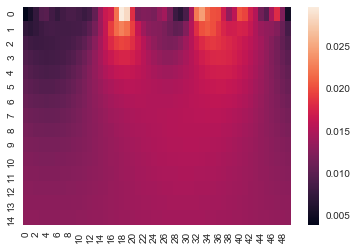

In [19]:
sns.heatmap(eqF_arr) # at equilibrium
# sigma on y
# num_demes on x

#### Heatmap of f over time and space without sampling for 1 replicate

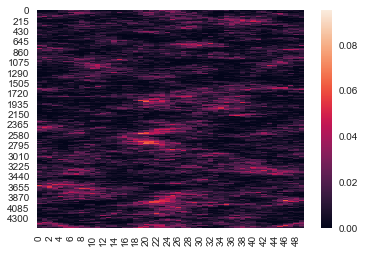

In [11]:
sns.heatmap(f[500:5000,0,:])

#### Sample across spatial lattice

In [28]:
sigma = 1
F = gaussian_filter1d(f,sigma=sigma,mode = "wrap")

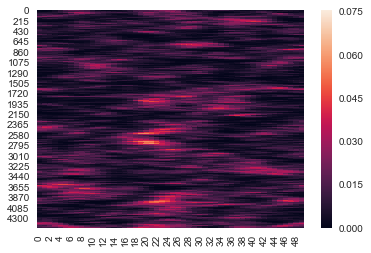

In [29]:
sns.heatmap(F[500:5000,0,:])

In [22]:
sigma = 5
F = gaussian_filter1d(f,sigma=sigma,mode = "wrap")

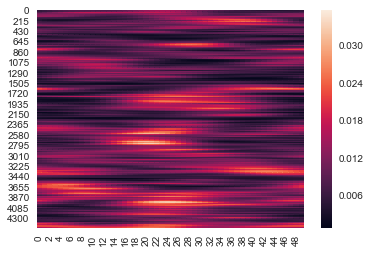

In [23]:
sns.heatmap(F[500:5000,0,:])

In [24]:
sigma = 10
F = gaussian_filter1d(f,sigma=sigma,mode = "wrap")

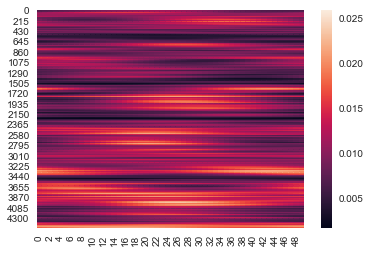

In [25]:
sns.heatmap(F[500:5000,0,:])

In [19]:
sigma = num_demes # 50
F = gaussian_filter1d(f,sigma=sigma,mode = "wrap")

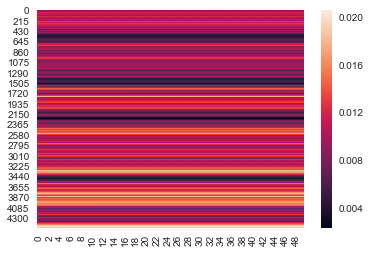

In [21]:
sns.heatmap(F[500:5000,0,:])

### $\langle \zeta \rangle$ calculator

In [35]:
from scipy.special import binom
def freq_sfs(f,n,i_min = 1,i_max = n-1):
    if np.isscalar(f):
        sfs = np.zeros(n+1)
    else:
        sfs = np.zeros(tuple([n+1]) + f.shape)
    for i in range(i_min,i_max+1):
        sfs[i] = binom(n,i)*f**i * (1-f)**(n-i)
    return sfs

## Usage, where F is an array of frequencies:
# avg_sfs = np.mean(freq_sfs(F, n, i_max))

In [49]:
sfs = freq_sfs(F,n=12,i_min=1,i_max=10)

In [51]:
# sfs = freq_sfs(F,n=12)
avg_sfs = np.mean(sfs,axis=(2,3))

In [52]:
avg_sfs

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.76572715e-01, 3.77062782e-01, 3.77638590e-01, ...,
        1.06213817e-01, 1.06380470e-01, 1.06493827e-01],
       [2.30127770e-01, 2.28553055e-01, 2.26673813e-01, ...,
        7.22160427e-03, 7.24886558e-03, 7.25498451e-03],
       ...,
       [5.34600000e-09, 5.09050945e-09, 4.77772896e-09, ...,
        4.77877246e-16, 5.05081532e-16, 4.48772947e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

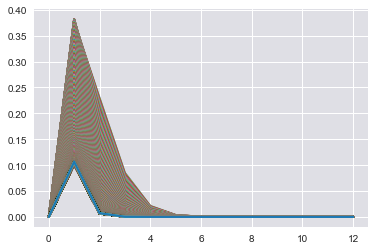

In [53]:
plt.plot(avg_sfs)
plt.show()

#### plot $\langle \zeta \rangle$

In [ ]:
plt.plot(np.mean(freq_sfs(F,2),axis = (2,3))[1].T,"-k",zorder=3, label='$\pi$')
plt.plot(np.mean(freq_sfs(F,100,i_min=1, i_max = 10),axis=(2,3))[1:11].T,"-")
plt.legend(loc = (0.8,0.8))
plt.show()

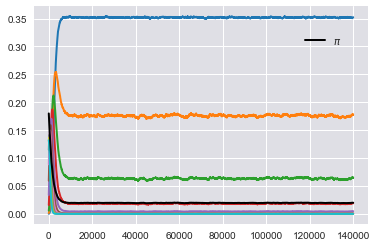

In [229]:
plt.plot(np.arange(num_gen+1)*s, np.mean(freq_sfs(F,2),axis = (2,3))[1].T,"-k",zorder=3, label='$\pi$')
plt.plot(np.arange(num_gen+1)*s, np.mean(freq_sfs(F,100,i_min=1, i_max = 10),axis=(2,3))[1:11].T,"-")
plt.legend(loc = (0.8,0.8))
plt.show()

#### Plot avg_sfs as a function of sigma and sample size

In [1]:
def avg_sfs_of_sigma(sigma,f,n,j):
    # sample from simulated frequencies
    F = gaussian_filter1d(f[-1],sigma=sigma,mode = "wrap")
    # calculate avg sfs
    sfs = freq_sfs(F,j,i_min=1, i_max = j)
    # average sampled F over demes
    avg_sfs = np.mean(sfs,axis=(2,3)).T
    return avg_sfs

In [2]:
x = avg_sfs_of_sigma(1,f,2,1)
x

NameError: name 'f' is not defined

In [312]:
# get avg sfs as a function of sigma for range of sigma
sig_max = 2
n = 2
j_max = 1
sigma_arr = np.arange(sig_max)+1

sfs_arr = np.zeros((sig_max,j+1))

for i in range(sig_max):
    sfs_arr[i] = avg_sfs_of_sigma(sigma_arr[i],f,n,j_max)

ValueError: could not broadcast input array from shape (2) into shape (3)

In [303]:
sfs_arr

array([[0.0101395, 0.0101395, 0.0101395],
       [0.0101395, 0.0101395, 0.0101395],
       [0.0101395, 0.0101395, 0.0101395],
       [0.0101395, 0.0101395, 0.0101395],
       [0.0101395, 0.0101395, 0.0101395],
       [0.0101395, 0.0101395, 0.0101395],
       [0.0101395, 0.0101395, 0.0101395],
       [0.0101395, 0.0101395, 0.0101395],
       [0.0101395, 0.0101395, 0.0101395],
       [0.0101395, 0.0101395, 0.0101395]])

In [293]:
sfs_arr.shape

(4, 3)

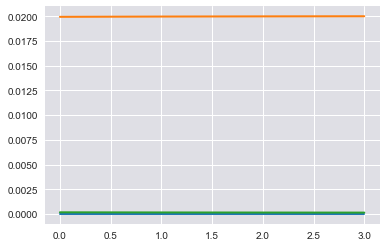

In [292]:
plt.plot(sfs_arr)

In [278]:
# for sigma goes from 1 to 10
sfs_arr

array([[0.        , 0.0200521 , 0.00011345],
       [0.        , 0.0200521 , 0.00011345],
       [0.        , 0.0200521 , 0.00011345],
       [0.        , 0.0200521 , 0.00011345],
       [0.        , 0.0200521 , 0.00011345],
       [0.        , 0.0200521 , 0.00011345],
       [0.        , 0.0200521 , 0.00011345],
       [0.        , 0.0200521 , 0.00011345],
       [0.        , 0.0200521 , 0.00011345],
       [0.        , 0.0200521 , 0.00011345]])

#### Troubleshooting
> avg sfs not changing with sigma

In [256]:
## sigma = 1
n = 10
j = 10
F1 = gaussian_filter1d(f,sigma=1,mode = "wrap")
avg_F1 = np.mean(F1,axis=2)
sfs1 = freq_sfs(avg_F1,n,i_min=1, i_max = j).T
print(avg_F1,"\n \n",sfs1[-1])

[[0.1     0.1     0.1     ... 0.1     0.1     0.1    ]
 [0.09806 0.09958 0.09654 ... 0.1004  0.0987  0.09758]
 [0.09704 0.09926 0.09464 ... 0.09796 0.09758 0.09496]
 ...
 [0.01352 0.01386 0.01122 ... 0.01248 0.00966 0.01178]
 [0.01452 0.01416 0.01126 ... 0.01228 0.009   0.01136]
 [0.0157  0.01534 0.01094 ... 0.01202 0.009   0.01084]] 
 
 [1.00000000e-10 9.26055102e-11 8.56162754e-11 ... 3.85910172e-19
 4.13277068e-19 4.29357019e-19]


In [257]:
## sigma = 2
n = 10
j = 10
F2 = gaussian_filter1d(f,sigma=2,mode = "wrap")
avg_F2 = np.mean(F2,axis=2)
sfs2 = freq_sfs(avg_F2,n,i_min=1, i_max = j).T
print(avg_F2,"\n \n",sfs2[-1])

[[0.1     0.1     0.1     ... 0.1     0.1     0.1    ]
 [0.09806 0.09958 0.09654 ... 0.1004  0.0987  0.09758]
 [0.09704 0.09926 0.09464 ... 0.09796 0.09758 0.09496]
 ...
 [0.01352 0.01386 0.01122 ... 0.01248 0.00966 0.01178]
 [0.01452 0.01416 0.01126 ... 0.01228 0.009   0.01136]
 [0.0157  0.01534 0.01094 ... 0.01202 0.009   0.01084]] 
 
 [1.00000000e-10 9.26055102e-11 8.56162754e-11 ... 3.85910172e-19
 4.13277068e-19 4.29357019e-19]


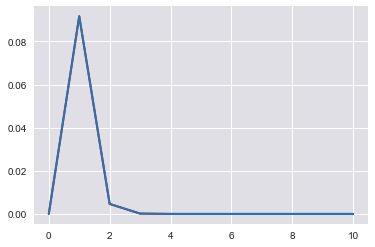

In [259]:
plt.plot(sfs1[-1],color="red")
plt.plot(sfs2[-1])
plt.show()

In [260]:
sfs1[-1] - sfs2[-1]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.23516474e-22, -1.32348898e-23, -3.10192730e-25, -3.23117427e-27,
       -1.26217745e-29, -9.86076132e-32, -1.92592994e-34])

In [261]:
print(np.mean(sfs1),np.mean(sfs2))

0.00928460682707314 0.00928460682707314


In [ ]:
#### TODO
# Change to implicit mutation based on bounce-back time

### $\pi$-plot scaled by $s$

### TO OPTIMIZE =>

In [234]:
def pi_plot(N,mu,s,num_reps,num_gen,p0,sigma,seed,xlim):
    np.random.seed(seed)
    f = SS_WF_sim(N,mu,s,m,num_reps,num_gen,num_demes,p0)
    avg_F = np.mean(gaussian_filter1d(f,sigma=sigma,mode = "wrap"),axis=2)
    plt.plot(np.arange(num_gen+1)*s, freq_sfs(avg_F,2,i_min=1, i_max = 1)[1],"-",zorder=3, label=f'$Ns = ${N*s}')
    plt.xlim(left = 0, right=xlim)
    plt.title(f'$\pi$ for demes = 1, mu = {mu}, N = {N}, time = {num_gen}')
    plt.legend()
#     plt.show()


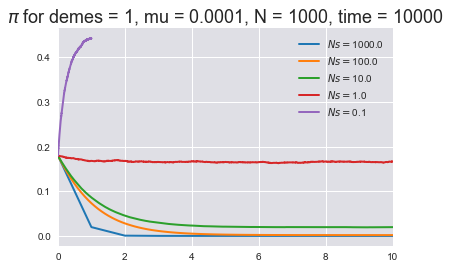

In [107]:
#### Takes a LONG time!
powers = np.arange(5)
s_arr = 1/np.power([10]*len(powers),powers)
xlim = 2*min(s_arr*num_gen)
for q in range(len(s_arr)):
    pi_plot(N,mu,s_arr[q],num_reps,num_gen,p0,sigma,seed=1,xlim=10)